<a href="https://colab.research.google.com/github/sambitdash/EVA-2/blob/master/Phase-2/Session-2/EVA_P2S2_File_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Using TensorFlow backend.


In [0]:
# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

In [3]:
step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

,0
0,1.915494
1,0.149318
2,1.856220
3,1.737805
4,0.170867


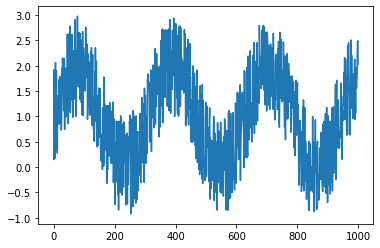

In [4]:
plt.plot(df)
plt.show()

In [0]:
values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)




Epoch 1/100





 - 10s - loss: 0.7613
Epoch 2/100
 - 0s - loss: 0.4496
Epoch 3/100
 - 0s - loss: 0.4148
Epoch 4/100
 - 0s - loss: 0.4012
Epoch 5/100
 - 0s - loss: 0.3944
Epoch 6/100
 - 0s - loss: 0.3918
Epoch 7/100
 - 0s - loss: 0.3879
Epoch 8/100
 - 0s - loss: 0.3887
Epoch 9/100
 - 0s - loss: 0.3873
Epoch 10/100
 - 0s - loss: 0.3854
Epoch 11/100
 - 0s - loss: 0.3832
Epoch 12/100
 - 0s - loss: 0.3869
Epoch 13/100
 - 0s - loss: 0.3839
Epoch 14/100
 - 0s - loss: 0.3832
Epoch 15/100
 - 0s - loss: 0.3819
Epoch 16/100
 - 0s - loss: 0.3805
Epoch 17/100
 - 0s - loss: 0.3794
Epoch 18/100
 - 0s - loss: 0.3806
Epoch 19/100
 - 0s - loss: 0.3775
Epoch 20/100
 - 0s - loss: 0.3765
Epoch 21/100
 - 0s - loss: 0.3771
Epoch 22/100
 - 0s - loss: 0.3775
Epoch 23/100
 - 0s - loss: 0.3762
Epoch 24/100
 - 0s - loss: 0.3777
Epoch 25/100
 - 0s - loss: 0.3766
Epoch 26/100
 - 0s - loss: 0.3760
Epoch 27/100
 - 0s - loss: 0.3739
Epoch 28/100
 - 0s - loss: 0.3719
Epoch 29/100
 - 0s - loss: 0.3745
Epoch 30/100
 

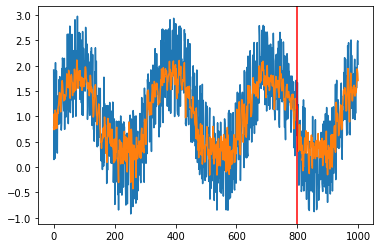

In [9]:
index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()